In [24]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_cvec_bi_a.pkl'
dest_model_file_b = model_folders + 'lda_cvec_bi_b.jlb'
dest_model_file_c = model_folders + 'lda_cvec_bi_c_dill.pkl'

gs_model_bk = './gs_models/cvec_bi.model'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 2)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

In [11]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [3]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [4]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [5]:
# Quickly clean the contexts
corpus = frame['lemma_text'].values

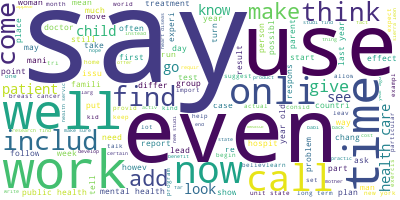

In [6]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:config.TRAIN_SIZE]
TRAIN_SIZE = config.TRAIN_SIZE +1
TEST_SIZE = config.TEST_SIZE + config.TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [6]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(ngram_range = GRAMMAGE,                  
                             analyzer='word',                  # Bi-grams
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,            # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [7]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

MemoryError: 

In [8]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [9]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -84407632.20001613
Perplexity:  8802.888613546991
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [10]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.9', 'n_components': 20}
Best Log Likelihood Score:  -28710554.94570543
Model Perplexity:  7169.483646137919


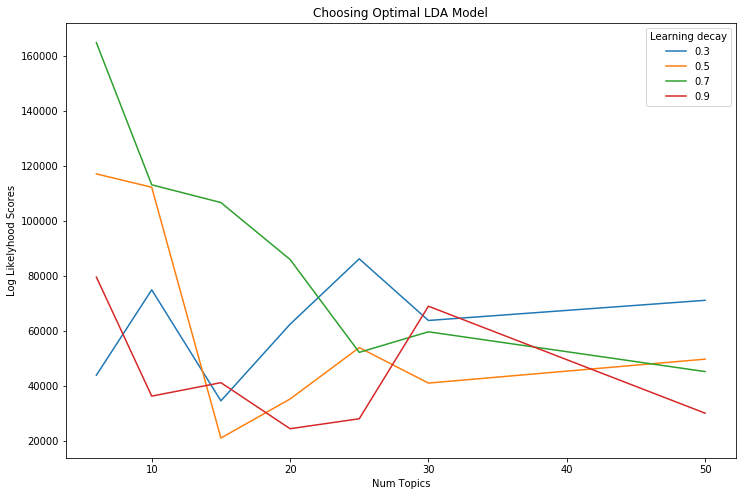

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Model to disk

In [15]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))



## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

In [44]:
# best_lda_model = dill.load(open(dest_model_file_c,'rb'))

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0,0,0.01,0,0,0,0.37,0,0.14,0,0.34,0.11,0,0,0,0.03,0,0,0,0,6
Doc1,0,0,0,0,0,0,0,0,0,0.34,0,0.55,0,0,0,0,0,0,0,0.08,11
Doc2,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0.09,0.21,0,0,0,0.19,0,2
Doc3,0,0,0,0.01,0,0.27,0,0,0.02,0,0,0.11,0,0,0,0,0,0,0,0.58,19
Doc4,0,0.08,0.61,0,0,0,0,0,0,0.31,0,0,0,0,0,0,0,0,0,0,2
Doc5,0,0,0,0,0,0.03,0.05,0.04,0,0,0,0.39,0,0,0,0,0,0,0,0.49,19
Doc6,0,0.06,0.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Doc7,0,0,0,0,0,0,0.1,0,0.33,0,0,0,0,0.57,0,0,0,0,0,0,13
Doc8,0,0,0,0,0,0,0.55,0,0.44,0,0,0,0,0,0,0,0,0,0,0,6
Doc9,0,0.14,0.27,0,0,0,0,0.01,0.07,0.13,0,0,0,0.26,0,0,0,0.08,0,0.03,2


In [ ]:
df_document_topics.to_csv(dest_files, sep='|',unicode='utf-8')

In [17]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,9,3277
1,18,2733
2,11,2224
3,2,2132
4,8,2108
5,10,1577
6,19,1559
7,6,1465
8,3,1412
9,16,1182


In [18]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.121716 -14.412184       1        1  11.089880
11     10.102979  35.908733       2        1   8.214005
18     20.495531 -43.306404       3        1   8.096634
8      53.087559  22.965542       4        1   8.017518
2      17.111225  65.577782       5        1   7.931471
10     72.114906  45.388420       6        1   6.467108
19     82.643616  14.175413       7        1   6.201453
6       6.874776 -13.687906       8        1   6.006430
1     -22.693640  -9.736867       9        1   5.679460
16     51.240318 -37.572498      10        1   4.717532
3      54.794186  -2.791355      11        1   4.297515
14    -11.043976 -38.273746      12        1   3.534964
0      48.897236  67.532341      13        1   3.249740
5      35.476929  41.417625      14        1   2.980709
13     78.094261 -19.415104      15        1   2.921777
15    -39.643684  14.516679      16        1   2.559424
4     -12.735651  60.678894      17        1   2.307317
17    -18.137375  32.726456      18        1   2.273475
7      26.932947  12.465928      19        1   1.868581
12     -0.502892  11.091010      20        1   1.585005, topic_info=       Category          Freq             Term         Total  loglift  logprob
term                                                                          
13109   Default  17994.000000           cancer  17994.000000  30.0000  30.0000
31731   Default  17760.000000             drug  17760.000000  29.0000  29.0000
16854   Default  20901.000000            child  20901.000000  28.0000  28.0000
76430   Default  39257.000000          patient  39257.000000  27.0000  27.0000
103411  Default  32522.000000            studi  32522.000000  26.0000  26.0000
113731  Default   9479.000000           vaccin   9479.000000  25.0000  25.0000
90710   Default  31545.000000         research  31545.000000  24.0000  24.0000
118118  Default  19970.000000            woman  19970.000000  23.0000  23.0000
13686   Default  28403.000000             care  28403.000000  22.0000  22.0000
46213   Default  53396.000000           health  53396.000000  21.0000  21.0000
70798   Default  10638.000000              nhs  10638.000000  20.0000  20.0000
40530   Default  16620.000000             food  16620.000000  19.0000  19.0000
114856  Default  10086.000000            virus  10086.000000  18.0000  18.0000
94777   Default   9559.000000           school   9559.000000  17.0000  17.0000
31429   Default   7073.000000            drink   7073.000000  16.0000  16.0000
53940   Default   6581.000000            insur   6581.000000  15.0000  15.0000
52860   Default  10924.000000           infect  10924.000000  14.0000  14.0000
84097   Default   7808.000000          product   7808.000000  13.0000  13.0000
12818   Default   8215.000000           calori   8215.000000  12.0000  12.0000
75749   Default   8092.000000           parent   8092.000000  11.0000  11.0000
38307   Default   8492.000000              fat   8492.000000  10.0000  10.0000
29480   Default  20017.000000           diseas  20017.000000   9.0000   9.0000
49137   Default  22559.000000           hospit  22559.000000   8.0000   8.0000
96237   Default  12345.000000           servic  12345.000000   7.0000   7.0000
32573   Default  11979.000000              eat  11979.000000   6.0000   6.0000
11706   Default   4944.000000           breast   4944.000000   5.0000   5.0000
15309   Default   6432.000000             cell   6432.000000   4.0000   4.0000
3535    Default   4596.000000          alcohol   4596.000000   3.0000   3.0000
74723   Default   6057.000000         outbreak   6057.000000   2.0000   2.0000
11346   Default   9513.000000            brain   9513.000000   1.0000   1.0000
...         ...           ...              ...           ...      ...      ...
23670   Topic20    225.035885            crash    722.366564   2.9783  -6.4839
96980   Topic20    125.888583  sexual t

In [19]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aap committe,...,zucchini lemon,zucchini onion,zucchini red,zucchini round,zucchini salt,zucchini veggi,zucker,zuckerman,zumba,zumba class
Topic0,0.050000,0.05,2.956316,0.05,0.358883,0.050000,0.050000,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
Topic1,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.050000,3.094907,0.05,0.05,...,11.05,11.05,14.05,20.05,13.05,12.05,0.05,0.05,0.050000,0.05
Topic2,0.541264,0.05,0.050000,0.05,2.881438,17.122900,3.805763,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,51.857344,22.05
Topic3,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.050000,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05
Topic4,0.050000,0.05,0.050000,0.05,0.050000,1.371645,0.050000,0.050000,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.05


In [20]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,cancer,woman,breast,test,breast cancer,screen,year,patient,treatment,risk,research,new,studi,lung,prostat
Topic 1,fat,calori,food,eat,sugar,make,oil,healthi,protein,add,fruit,serv,salt,gram,low
Topic 2,weight,exercis,bodi,eat,sleep,time,day,food,peopl,make,diet,run,help,studi,activ
Topic 3,health,insur,care,plan,state,peopl,coverag,law,year,cost,health insur,pay,feder,exchang,afford
Topic 4,drink,alcohol,studi,peopl,research,health,disord,skin,medic,problem,eat,risk,effect,patient,adult
Topic 5,nhs,care,servic,patient,need,peopl,health,social,make,healthcar,chang,organis,year,local,improv
Topic 6,studi,research,diseas,peopl,risk,heart,blood,effect,high,year,caus,new,health,trial,patient
Topic 7,patient,health,nurs,hospit,need,care,peopl,make,time,sexual,mental,think,duncan,support,feel
Topic 8,woman,health,child,studi,research,year,age,high,report,risk,rate,peopl,percent,babi,obes
Topic 9,peopl,year,just,make,time,think,know,want,feel,life,come,day,help,thing,tell


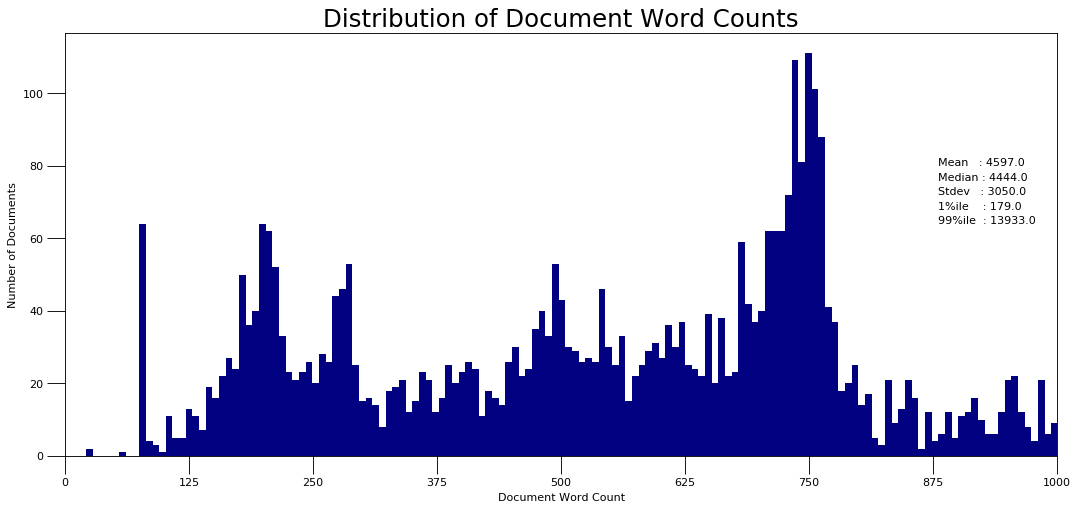

In [21]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [22]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [25]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[9.14076796e-05 2.75786642e-01 2.33416912e-01 9.14076807e-05
  9.40026077e-03 9.14076795e-05 2.59882298e-01 9.14076794e-05
  7.55982664e-02 9.14076799e-05 9.14076799e-05 1.49286782e-02
  9.14076793e-05 9.14076791e-05 1.15082826e-01 9.14076807e-05
  9.14076810e-05 1.48072237e-02 9.14076797e-05 9.14076807e-05]] 1
['fat', 'calori', 'food', 'eat', 'sugar', 'make', 'oil', 'healthi', 'protein', 'add', 'fruit', 'serv', 'salt', 'gram', 'low']
array([[9.14076796e-05, 2.75786642e-01, 2.33416912e-01, 9.14076807e-05,
        9.40026077e-03, 9.14076795e-05, 2.59882298e-01, 9.14076794e-05,
        7.55982664e-02, 9.14076799e-05, 9.14076799e-05, 1.49286782e-02,
        9.14076793e-05, 9.14076791e-05, 1.15082826e-01, 9.14076807e-05,
        9.14076810e-05, 1.48072237e-02, 9.14076797e-05, 9.14076807e-05]])


### Fitting with KMeans

Component's weights: 
 [[ 0.07  0.09  0.27  0.12  0.04  0.03  0.16  0.03  0.27  0.62  0.2   0.31
   0.03  0.07  0.1   0.08  0.13  0.05  0.44  0.2 ]
 [-0.02 -0.07 -0.24 -0.06 -0.02 -0.01 -0.01  0.01 -0.05 -0.36 -0.11 -0.11
   0.    0.02 -0.01 -0.01 -0.04 -0.03  0.88 -0.03]]
Perc of Variance Explained: 
 [0.03 0.13]


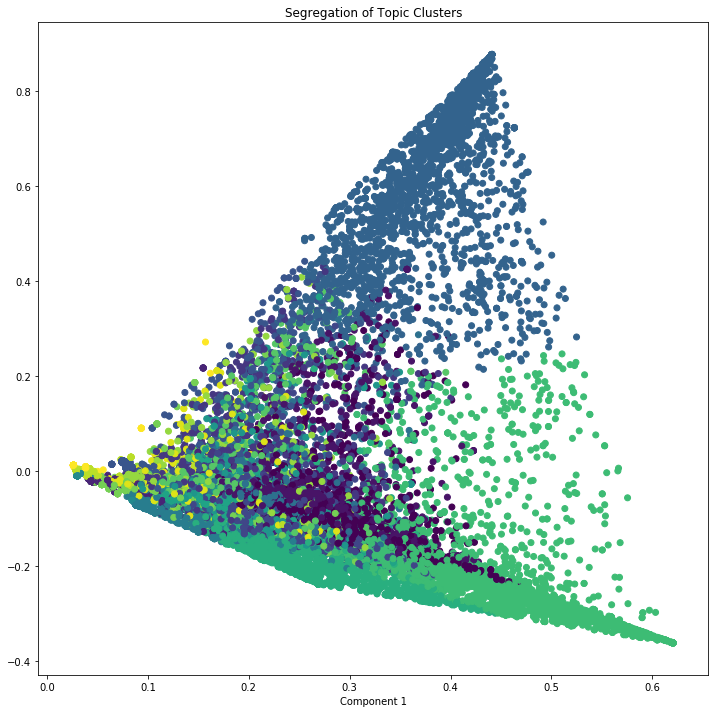

In [27]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [28]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [29]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[9.14076796e-05 2.75786642e-01 2.33416912e-01 9.14076807e-05
  9.40026077e-03 9.14076795e-05 2.59882298e-01 9.14076794e-05
  7.55982664e-02 9.14076799e-05 9.14076799e-05 1.49286782e-02
  9.14076793e-05 9.14076791e-05 1.15082826e-01 9.14076807e-05
  9.14076810e-05 1.48072237e-02 9.14076797e-05 9.14076807e-05]] 1
Topic KeyWords:  ['fat', 'calori', 'food', 'eat', 'sugar', 'make', 'oil', 'healthi', 'protein', 'add', 'fruit', 'serv', 'salt', 'gram', 'low']
Topic Prob Scores of text:  [[0.  0.3 0.2 0.  0.  0.  0.3 0.  0.1 0.  0.  0.  0.  0.  0.1 0.  0.  0.
  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.3 0.2 0.  0.  0.  0.3 0.  0.1 0.  0.  0.  0.  0.  0.1 0.  0.  0.
  0.  0. ]]

 say cinnamon say sugar popular combin cours re interest health promot effect cinnamon may want think anew spice instanc say execut chef bourbon steak restaur washington whi not add savori dish use cinnamon creat spice herb rub lamb loin also whip great spinach salad raisin pine nut cinnamon critchley be fan intens

### Fitting with DBSCAN

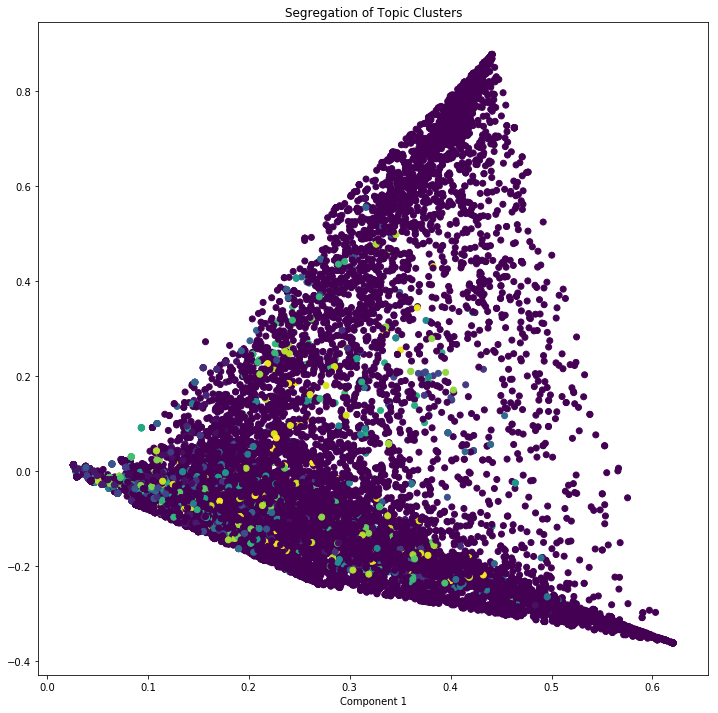

In [30]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)